<a href="https://colab.research.google.com/github/majavk/Data_Science_Portfolio/blob/main/project_walmart_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of walmart Weekly Sales

##Introduction

Description:

One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to the inappropriate machine learning algorithm. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.

##Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import f_oneway
from scipy.special import inv_boxcox

##Data cleaning

There are no duplicated rows and no missing values in the dataset.

In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.weekday
df = df.drop('Date', axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   year          6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   day           6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.475524,3.573427
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.321797,1.426581
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,0.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,4.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,4.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,4.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,6.000000


##Exploratory data analysis

###Univariate distribution

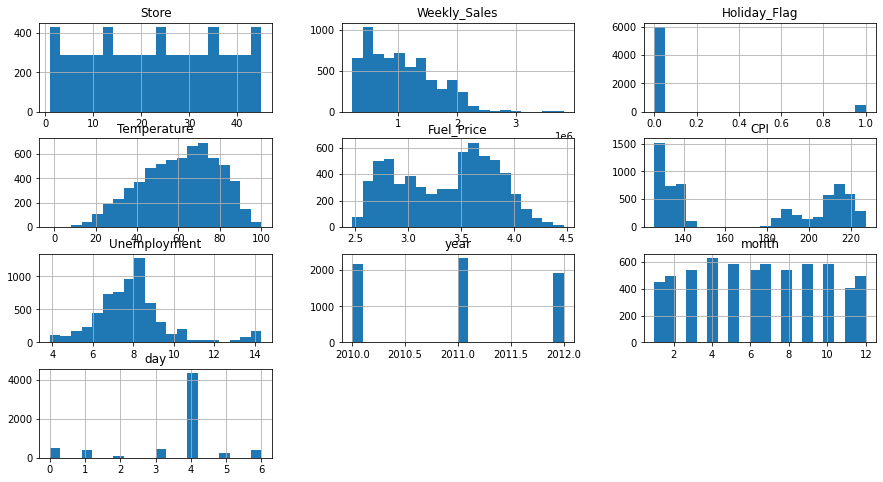

In [ ]:
df.hist(bins = 20, xlabelsize = 10, ylabelsize = 10, figsize=(15,8))
plt.show()

###Bivariate distribution

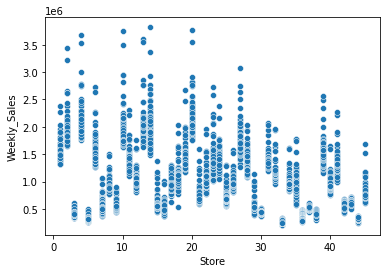

In [ ]:
sns.scatterplot(x='Store', y='Weekly_Sales', data=df)

The 'Weekly Sales' column is showing specific dependence on 'CPI' column.
The 'CPI' column is divided in 3 bins and converted to categorical variable
with the values 'low', 'medium' and 'high'.

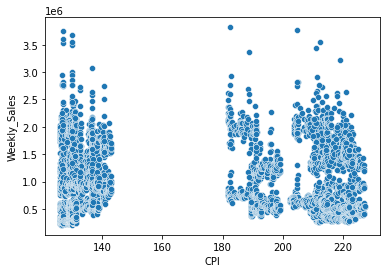

In [ ]:
sns.scatterplot(x='CPI', y='Weekly_Sales', data=df)

In [ ]:
df['CPI'] = pd.cut(df.CPI,bins=[0,160,200,250],labels=['low','med','high'])


In [ ]:
df['CPI'].value_counts()

low     3146
high    2431
med      858
Name: CPI, dtype: int64

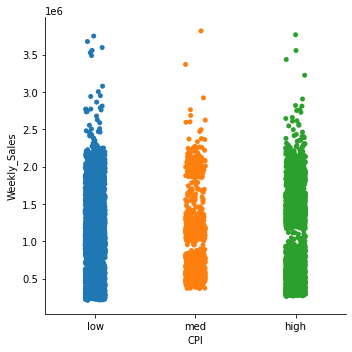

In [ ]:
sns.catplot(x='CPI', y='Weekly_Sales', data=df)

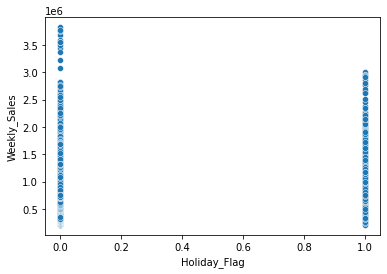

In [ ]:
sns.scatterplot(x='Holiday_Flag', y='Weekly_Sales', data=df)

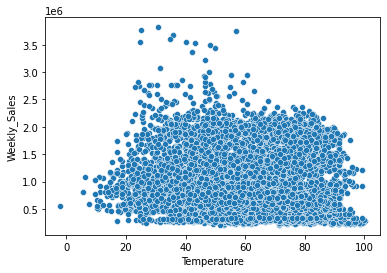

In [ ]:
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df)

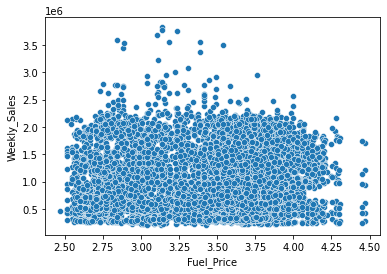

In [ ]:
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=df)

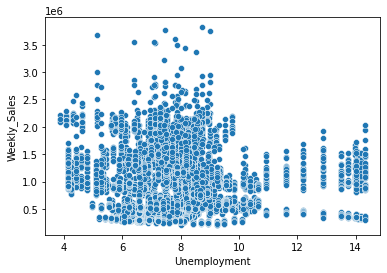

In [ ]:
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=df)

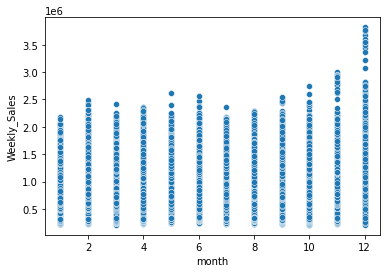

In [ ]:
sns.scatterplot(x='month', y='Weekly_Sales', data=df)

In [ ]:
df = df[['Weekly_Sales','Temperature','Store','Holiday_Flag', 'CPI','Unemployment','Fuel_Price','month']]

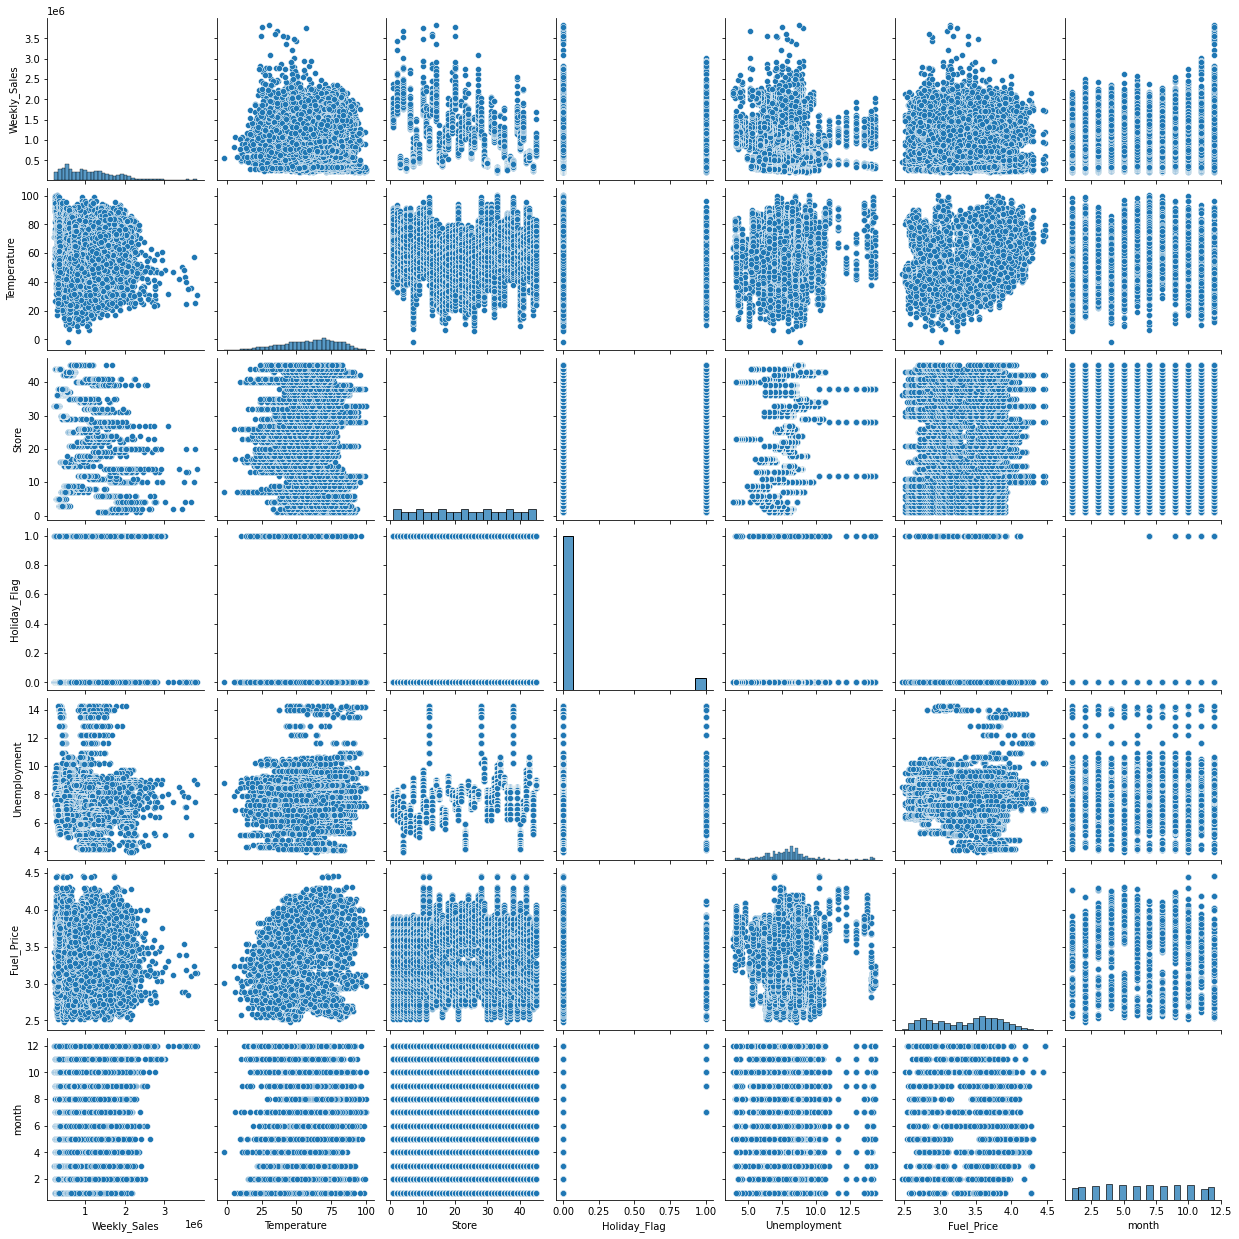

In [ ]:
sns.pairplot(df)

##Feature engineering

### One hot encoding

,Weekly_Sales,Temperature,Store,Unemployment,Fuel_Price,month,OHE_1,OHE_med,OHE_high
0,1643690.90,42.31,1,8.106,2.572,5,0,0,1
1,1641957.44,38.51,1,8.106,2.548,12,1,0,1
2,1611968.17,39.93,1,8.106,2.514,2,0,0,1
3,1409727.59,46.63,1,8.106,2.561,2,0,0,1
4,1554806.68,46.50,1,8.106,2.625,5,0,0,1


###Symmetry of the target variable 'Weekly Sales'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


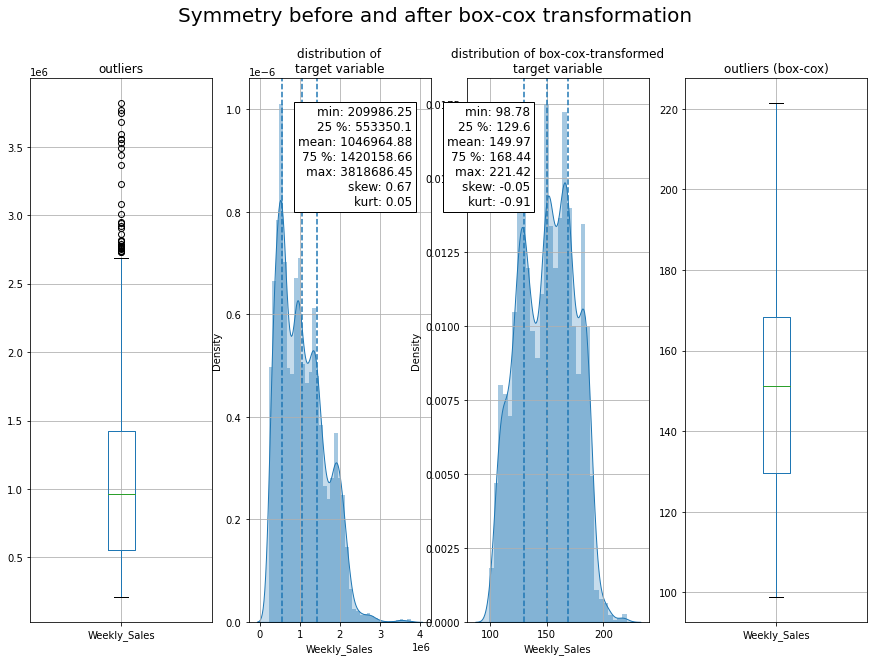

###Train test split and box-cox transformation of the target variable

In [ ]:
X = df_ohe.drop('Weekly_Sales', axis=1)
y = df_ohe['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=404)
y_train_bc = stats.boxcox(y_train)[0]

###Polynomial features transformation

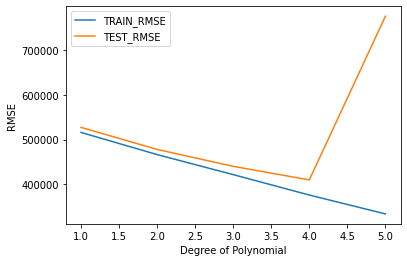

In [ ]:
poly_converter = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly_converter.fit_transform(X_train)
X_test_poly = poly_converter.transform(X_test)


###KFold split of the train data 

In [ ]:
kf = KFold(shuffle=True, random_state=404, n_splits=5)
for train_index, test_index in kf.split(X_train, y_train):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 0  1  2  4  5  6  7  8 10 11] 4118
Test index: [ 3  9 16 19 23 25 35 45 49 53] 1030

Train index: [ 1  2  3  4  6  7  8  9 10 11] 4118
Test index: [ 0  5 13 26 28 34 40 43 47 48] 1030

Train index: [ 0  1  2  3  5  6  7  9 10 11] 4118
Test index: [ 4  8 20 30 39 41 42 44 52 55] 1030

Train index: [ 0  3  4  5  6  7  8  9 10 11] 4119
Test index: [ 1  2 12 14 18 24 29 31 33 36] 1029

Train index: [ 0  1  2  3  4  5  8  9 12 13] 4119
Test index: [ 6  7 10 11 15 17 21 22 27 32] 1029



##Regression

###Linear Regression

The baseline model, linear regression with the scaled features.

In [ ]:
estimator = Pipeline([("scaler", StandardScaler()),
                         ("linear_regression", LinearRegression())])


estimator.fit(X_train,y_train)


print(f'r squared on the train set: {round(r2_score(y_train, estimator.predict(X_train)),5)}') 

print(f'r squared on the test set: {round(r2_score(y_test, estimator.predict(X_test)),5)}')

r squared on the train set: 0.1436
r squared on the test set: 0.14372


Linear regression using polynomial scaled features. 

In [ ]:
estimator_lr = Pipeline([("poly_converter", PolynomialFeatures(degree=4, include_bias=False)),
                         ("scaler", StandardScaler()),
                         ("linear_regression", LinearRegression())])


estimator_lr.fit(X_train,y_train)


print(f'r squared on the train set: {round(r2_score(y_train, estimator_lr.predict(X_train)),5)}') 

print(f'r squared on the test set: {round(r2_score(y_test, estimator_lr.predict(X_test)),5)}')

r squared on the train set: 0.5411
r squared on the test set: 0.52759


Linear regression using polynomial scaled features and box-cox transformed target. 

In [ ]:
estimator = Pipeline([("poly_converter", PolynomialFeatures(degree=4, include_bias=False)),
                      ("scaler", StandardScaler()),
                      ("linear_regression", LinearRegression(fit_intercept=True))])


estimator.fit(X_train,y_train_bc)

lam = stats.boxcox(y_train)[1]
inv_predictions = inv_boxcox(estimator.predict(X_test), lam)

print(f'r squared on the train set: {round(r2_score(y_train_bc, estimator.predict(X_train)),5)}') 

print(f'r squared on the test set: {round(r2_score(y_test, inv_predictions),5)}')

r squared on the train set: 0.52877
r squared on the test set: 0.50058


###Ridge Regression

In [ ]:
estimator = Pipeline([("poly_converter", PolynomialFeatures(degree=4, include_bias=False)),
                      ("scaler", StandardScaler()),
                      ("ridge_regression", Ridge())])

params = {'ridge_regression__alpha': np.geomspace(0.1, 20, 10)}
estimator.fit(X_train,y_train)

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X_train,y_train)

print(f'r squared on the train set: {round(r2_score(y_train, estimator.predict(X_train)),5)}') 

print(f'r squared on the test set: {round(r2_score(y_test, estimator.predict(X_test)),5)}')

r squared on the train set: 0.47194
r squared on the test set: 0.47861


###Lasso Regression

In [ ]:
estimator = Pipeline([("poly_converter", PolynomialFeatures(degree=4, include_bias=False)),
                      ("scaler", StandardScaler()),
                      ("lasso", Lasso())])
estimator.fit(X_train,y_train)
params = {'lasso__alpha': np.geomspace(0.1, 20, 10)}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X_train,y_train)


print(f'r squared on the train set: {round(r2_score(y_train, estimator_lr.predict(X_train)),5)}') 

print(f'r squared on the test set: {round(r2_score(y_test, estimator_lr.predict(X_test)),5)}')

###Elastic Net

In [ ]:
estimator = Pipeline([("poly_converter", PolynomialFeatures(degree=4, include_bias=False)),
                      ("scaler", StandardScaler()),
                      ("elastic_net", ElasticNet())])

estimator.fit(X_train,y_train)
params = {'elastic_net__alpha': np.geomspace(0.1, 30, 10), 'elastic_net__max_iter':[100000], 'elastic_net__l1_ratio':[0.1, 0.04, 0.05, 0.8, 1.]}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X_train,y_train)


print(f'r squared on the train set: {round(r2_score(y_train, estimator.predict(X_train)),5)}') 

print(f'r squared on the test set: {round(r2_score(y_test, estimator.predict(X_test)),5)}')

In [ ]:
importance = estimator_lr.named_steps['linear_regression'].coef_
importance = np.sort(importance)
feature_names = poly_converter.get_feature_names_out()

df_importances = pd.DataFrame({"Importance": importance, "Feature": feature_names}).sort_values("Importance", ascending=False)
df_importances = df_importances.set_index('Feature')

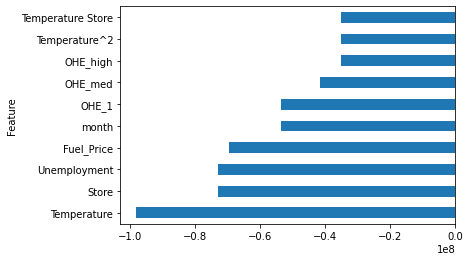

In [ ]:
df_importances.sort_values(by="Importance").head(10).plot(kind="barh", legend=False)
plt.show()

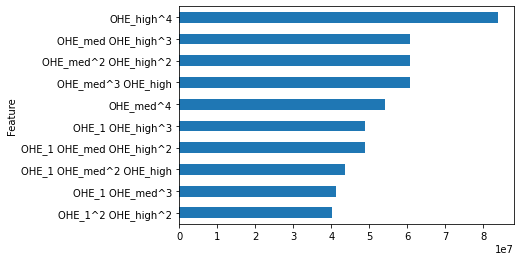

In [ ]:
df_importances.sort_values(by="Importance").tail(10).plot(kind="barh", legend=False)
plt.show()

##Conclusion

The linear regression using the polynomial feature of degree 4, gave the best prediction result. The model explains 52.7% of variance in data.

1. r squared on the train set: 0.5411
2. r squared on the test set: 0.52759

The data set should be further analysed to improve the prediction.
The most important features were 'Temperature' and 'OHE_high^4', so the 'CPI' in the high range.

The regularization penalty terms in the loss function didn't improve the model.
